In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
from utils import *

In [2]:
def load_all_data(dir, filecnt=54):
    data = [None]*10
    t = np.zeros((10, filecnt), int)
    for p in range(10):
        d = [None]*filecnt
        for i in range(filecnt):
            d[i] = np.load(f"{dir}/{p}/{i+1}.npy")
            t[p,i] = d[i].shape[0]
        data[p] = d
    return data, t

def load_with_config(dir, config_path, load_nonvalid=False):
    config_arr = np.array(pd.read_csv(f"{config_path}", header=None, skiprows=1))
    data = [[] for i in range(10)]          #create empty 2d list : (10, unknown)
    for config in config_arr:
        #valid check
        if (not config[2]) and (not load_nonvalid):
            continue
        data[int(config[0])] += [np.load(f"{dir}/{int(config[0])}/{int(config[1])+1}.npy")[int(config[3]):int(config[4]),:]]
    
    return data, config_arr

def match_length(d, t:int):
    """
    return
        x : (N, times(t), 2) shape numpy array,
        y : (N)
    """
    N = sum([len(d[i]) for i in range(len(d))])
    x = np.zeros((N, t, 2), np.float64)
    y = np.zeros((N), np.float64)
    target_timepoints = np.linspace(0, 1, t)
    start_at = 0
    for r in range(len(d)):
        for c in range(len(d[r])):
            origin_timepoints = np.linspace(0, 1, d[r][c].shape[0])
            x[start_at + c, :, 0] = np.interp(target_timepoints, origin_timepoints, d[r][c][:,0])
            x[start_at + c, :, 1] = np.interp(target_timepoints, origin_timepoints, d[r][c][:,1])
        y[start_at:start_at + len(d[r])] = r
        start_at += len(d[r])
    return x, y 

def apply_normalize(d):
    for r in range(len(d)):
        for c in range(len(d[r])):
            channels = d[r][c].shape[1]
            min_vals = np.min(d[r][c][:, :], axis=0)
            max_vals = np.max(d[r][c][:, :], axis=0)
            min_max_diff = np.array([max_vals[j] - min_vals[j] for j in range(channels)])
            factor = min_max_diff / np.max(min_max_diff)
            for ch in range(channels):
                d[r][c][:, ch] = ((d[r][c][:, ch] - min_vals[ch])/min_max_diff[ch])*factor[ch]
    
def plot_data(d):
    plt.figure(figsize=(20,4))
    plt.subplot(2,1,1)
    gca = plt.gca()
    gca.plot(d[:,0])
    plt.subplot(2,1,2)
    gca = plt.gca()
    gca.plot(d[:,1])
    plt.tight_layout()
    plt.show()

def plot_data2(d, save=None, cmap_name="gist_rainbow", xlim1=None, ylim1=None, xlim2=None, ylim2=None, xlim3=None, ylim3=None):
    fig, axes = plt.subplot_mosaic("abbbb;acccc", figsize=(20,4))
    draw_gradation(d[:,0], d[:,1], axes["a"],cmap_name=cmap_name, xlim=xlim1, ylim=ylim1)
    draw_gradation(np.arange(d.shape[0]), d[:,0], axes["b"],cmap_name=cmap_name, xlim=xlim2, ylim=ylim2)
    draw_gradation(np.arange(d.shape[0]), d[:,1], axes["c"],cmap_name=cmap_name, xlim=xlim3, ylim=ylim3)

    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save)
        plt.close()

def plot_data3(origin, syn, save, cmap_name="gist_rainbow"):
    fig, axes = plt.subplot_mosaic("abbbb;acccc;deeee;dffff", figsize=(20,8))
    draw_gradation(origin[:,0], origin[:,1], axes["a"],cmap_name=cmap_name, xlim=[0,1], ylim=[0,1])
    draw_gradation(np.arange(origin.shape[0]), origin[:,0], axes["b"],cmap_name=cmap_name, ylim=[0,1])
    draw_gradation(np.arange(origin.shape[0]), origin[:,1], axes["c"],cmap_name=cmap_name, ylim=[0,1])
    draw_gradation(syn[:,0], syn[:,1], axes["d"], cmap_name=cmap_name, xlim=[0,1], ylim=[0,1])
    draw_gradation(np.arange(syn.shape[0]), syn[:,0], axes["e"],cmap_name=cmap_name, ylim=[0,1])
    draw_gradation(np.arange(syn.shape[0]), syn[:,1], axes["f"],cmap_name=cmap_name, ylim=[0,1])
    axes["a"].set_title("Original")
    axes["d"].set_title("Synthetic")

    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save)
        plt.close()

In [3]:
data, config = load_with_config("/home/user/workspace/research/eye-writing/self_data/", "/home/user/workspace/research/eye-writing/load_data_config.csv", load_nonvalid=False)
apply_normalize(data)
# plot_data2(data[9][53], xlim1=[0, 1], ylim1=[0,1], ylim2=[0,1], ylim3=[0,1])

In [4]:
# target_data = data
# save_dir = "/home/user/img"
# for r in range(len(target_data)):
#     target_pattern_config = config[config[:,0] == r, :]
#     indexes = target_pattern_config[target_pattern_config[:,2]==1, 1]
#     print(f"pattern {r}, length = {len(target_data[r])}, indexes len = {indexes.shape}")
#     for c in range(len(target_data[r])):
#         plot_data2(target_data[r][c], save=f"{save_dir}/Pattern_{r}_Index_{indexes[c]}.png", cmap_name="gist_rainbow", xlim1=[0, 1], ylim1=[0,1], ylim2=[0,1], ylim3=[0,1])

In [5]:
x, y = match_length(data, 200)
print(x.shape)
print(y.shape)
pattern = 0
x = x[y==pattern]
print(x.shape)


(505, 200, 2)
(505,)
(51, 200, 2)


In [6]:
# target_data = x
# save_dir = "/home/user/img"
# for i in range(len(target_data)):
#     plot_data2(target_data[i], f"{save_dir}/{i}.png", "gist_rainbow",  xlim1=[0, 1], ylim1=[0,1], ylim2=[0,1], ylim3=[0,1])

In [7]:
import tensorflow as tf
import tensorflow.keras as keras
from tqdm import trange

def get_model(input_shape, output_units, rnn_units, layer_cnt):
    inputs = keras.layers.Input(input_shape)
    x = inputs
    for i in range(layer_cnt):
        x = keras.layers.GRU(rnn_units, return_sequences=True)(x)
    outputs = keras.layers.Dense(output_units, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

def timegan_init(time_series_len, features, rnn_units, rnn_layers):
    input_shape = (time_series_len, features)
    latent_code_shape = (time_series_len, rnn_units)
    embedder = get_model(input_shape, rnn_units, rnn_units, rnn_layers)
    generator = get_model(input_shape, rnn_units, rnn_units, rnn_layers)
    supervisor = get_model(latent_code_shape, rnn_units, rnn_units, rnn_layers)
    recovery = get_model(latent_code_shape, features, rnn_units, rnn_layers)
    discriminator = get_model(latent_code_shape, 1, rnn_units, rnn_layers-1)
    return embedder, generator, supervisor, recovery, discriminator

def timegan_export_generator(timegan_tuple):
    _, generator, supervisor, recovery, _ = timegan_tuple
    syn_gen_input = keras.Input(generator.input_shape[1:])
    syn_gen_output = generator(syn_gen_input)
    syn_gen_output = supervisor(syn_gen_output)
    syn_gen_output = recovery(syn_gen_output)
    return keras.Model(syn_gen_input, syn_gen_output)
    
def timegan_train(x, timegan_tuple, epochs, batch_size, learning_rate):
    embedder, generator, supervisor, recovery, discriminator = timegan_tuple

    #random_vector에 쓰이는 np.random.uniform()이 float32기 때문에 타입을 맞춰줌(안맞추면 에러남)
    x = x.astype(np.float32)
    mini_batch = lambda x, batch_size : x[np.random.permutation(x.shape[0])[:batch_size]]

    #loss & optimizer
    mse = keras.losses.MeanSquaredError()
    bce = keras.losses.BinaryCrossentropy()
    opt_autoencoder = keras.optimizers.Adam(learning_rate=learning_rate)
    opt_supervisor = keras.optimizers.Adam(learning_rate=learning_rate)
    opt_generator = keras.optimizers.Adam(learning_rate=learning_rate)
    opt_embedder = keras.optimizers.Adam(learning_rate=learning_rate)
    opt_discriminator = keras.optimizers.Adam(learning_rate=learning_rate)

    #train autoencoder
    print(f"train autoencoder")
    for _ in trange(epochs):
        batch = mini_batch(x, batch_size)
        with tf.GradientTape() as tape:
            y_true = embedder(batch)
            y_true = recovery(y_true)
            loss = 10 * tf.sqrt(mse(y_true, batch))
        var_list = embedder.trainable_variables + recovery.trainable_variables
        gradients = tape.gradient(loss, var_list)
        opt_autoencoder.apply_gradients(zip(gradients, var_list))

    #train supervisor
    print(f"train supervisor") 
    for _ in trange(epochs):
        batch = mini_batch(x, batch_size)
        with tf.GradientTape() as tape:
            y_true = embedder(batch)
            y_pred = supervisor(y_true)
            loss = mse(y_true[:, 1:, :], y_pred[:, :-1, :])
        var_list = generator.trainable_variables + supervisor.trainable_variables
        gradients = tape.gradient(loss, var_list)
        #이거 안하면 TF2 WARNING : Gradients do not exist for variables 발생
        #var_list에 계산과정에 없던 generator있어서 그런거 같은데, 정확한 원인은 모르겠음.
        apply_grads = [(grad, var) for (grad, var) in zip(gradients, var_list) if grad is not None]
        opt_autoencoder.apply_gradients(apply_grads)

    #joint train
    print(f"joint train")
    for _ in trange(epochs):
        for __ in range(2):
            batch = mini_batch(x, batch_size)
            random_vector = np.random.uniform(size=batch.shape)
            #train generator
            with tf.GradientTape() as tape:
                #supervised loss
                y_true = embedder(batch)
                y_pred = supervisor(y_true)
                supervised_loss = mse(y_true[:, 1:, :], y_pred[:, :-1, :])

                #unsupervised loss
                y_true = tf.ones((batch_size, x.shape[1], 1))
                y_pred = generator(random_vector)
                y_pred = supervisor(y_pred)
                y_pred = discriminator(y_pred)
                unsupervised_loss = bce(y_true, y_pred)

                #unsupervised loss - E
                y_true = tf.ones((batch_size, x.shape[1], 1))
                y_pred = generator(random_vector)
                y_pred = discriminator(y_pred)
                unsupervised_loss_e = bce(y_true, y_pred)

                #moment loss
                y_true = batch
                y_pred = generator(random_vector)
                y_pred = supervisor(y_pred)
                y_pred = recovery(y_pred)
                y_true_mean, y_true_var = tf.nn.moments(y_true, axes=[0])
                y_pred_mean, y_pred_var = tf.nn.moments(y_pred, axes=[0])
                v1 = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
                v2 = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
                moment_loss = v1 + v2

                loss = supervised_loss + 100 * tf.sqrt(unsupervised_loss) + unsupervised_loss_e + 100 * moment_loss

            var_list = generator.trainable_variables + supervisor.trainable_variables
            gradients = tape.gradient(loss, var_list)
            opt_generator.apply_gradients(zip(gradients, var_list))

            #train embedder
            with tf.GradientTape() as tape:
                #supervised loss
                y_true = embedder(batch)
                y_pred = supervisor(y_true)
                supervised_loss = mse(y_true[:, 1:, :], y_pred[:, :-1, :])

                #reconstruction loss
                y_true = embedder(batch)
                y_true = recovery(y_true)
                y_pred = batch
                reconstruction_loss = 10 * tf.sqrt(mse(y_true, y_pred))

                loss = reconstruction_loss + 0.1 * supervised_loss

            var_list = embedder.trainable_variables + recovery.trainable_variables
            gradients = tape.gradient(loss, var_list)
            opt_embedder.apply_gradients(zip(gradients, var_list))

        batch = mini_batch(x, batch_size)
        random_vector = np.random.uniform(size=batch.shape)
        #train discriminator
        with tf.GradientTape() as tape:
            #loss on FN
            y_true = tf.ones((batch_size, x.shape[1], 1))
            y_pred = embedder(batch)
            y_pred = discriminator(y_pred)
            loss_on_FN = bce(y_true, y_pred)

            #loss on FP
            y_true = tf.zeros((batch_size, x.shape[1], 1))
            y_pred = generator(random_vector)
            y_pred = supervisor(y_pred)
            y_pred = discriminator(y_pred)
            loss_on_FP = bce(y_true, y_pred)

            #loss on FP - E
            y_true = tf.zeros((batch_size, x.shape[1], 1))
            y_pred = generator(random_vector)
            y_pred = discriminator(y_pred)
            loss_on_FP_E = bce(y_true, y_pred)           

            loss = loss_on_FN + loss_on_FP + loss_on_FP_E

        var_list = discriminator.trainable_variables
        gradients = tape.gradient(loss, var_list)
        opt_discriminator.apply_gradients(zip(gradients, var_list))

    return embedder, generator, supervisor, recovery, discriminator

def generator_save(syn_gen, save_path, only_weights=True):
    if only_weights:
        syn_gen.save_weights(save_path)
    else:
        raise NotImplementedError

def generator_load(save_path):
    raise NotImplementedError

def generator_load_weights(save_path, time_series_len, features, rnn_units, rnn_layers):
    timegan = timegan_init(time_series_len, features, rnn_units, rnn_layers)
    syn_gen = timegan_export_generator(timegan)
    syn_gen.load_weights(save_path)
    return syn_gen

def generator_gen(syn_gen, generate_cnt):
    syn = syn_gen.predict(np.random.uniform(size=(generate_cnt, syn_gen.input_shape[1], syn_gen.input_shape[2])))
    return syn


In [8]:
rnn_units = 24
rnn_layers = 3
batch_size = 32
lr = 0.0005
epoch = 2000
save_name = f"/home/user/backup/synckpt_test_{pattern}/"
import os

if os.path.isdir(save_name):
    print(f"체크포인트 있음, 불러옴.")
    syn_gen = generator_load_weights(save_name, x.shape[1], x.shape[2], rnn_units, rnn_layers)
else:
    timegan_tuple = timegan_init(x.shape[1], x.shape[2], rnn_units, rnn_layers)
    timegan_tuple = timegan_train(x, timegan_tuple, epochs=epoch, batch_size=batch_size, learning_rate=lr)
    # syn_gen = timegan_export_generator(timegan_tuple)
    # generator_save(syn_gen, save_name)

2023-02-10 04:42:34.124367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-10 04:42:34.134481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-10 04:42:34.134814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-10 04:42:34.135771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

train autoencoder


  0%|          | 0/2000 [00:00<?, ?it/s]2023-02-10 04:42:38.040168: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-02-10 04:42:38.886919: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 2000/2000 [04:41<00:00,  7.09it/s]


train supervisor


100%|██████████| 2000/2000 [04:40<00:00,  7.13it/s]


joint train


 18%|█▊        | 356/2000 [12:48<58:25,  2.13s/it]  

In [ ]:
# synth_data = generator_gen(syn_gen, batch_size)
# synth_data.shape
e, g, s, r ,d = timegan_tuple
synth_data = e(x)
synth_data = r(synth_data)

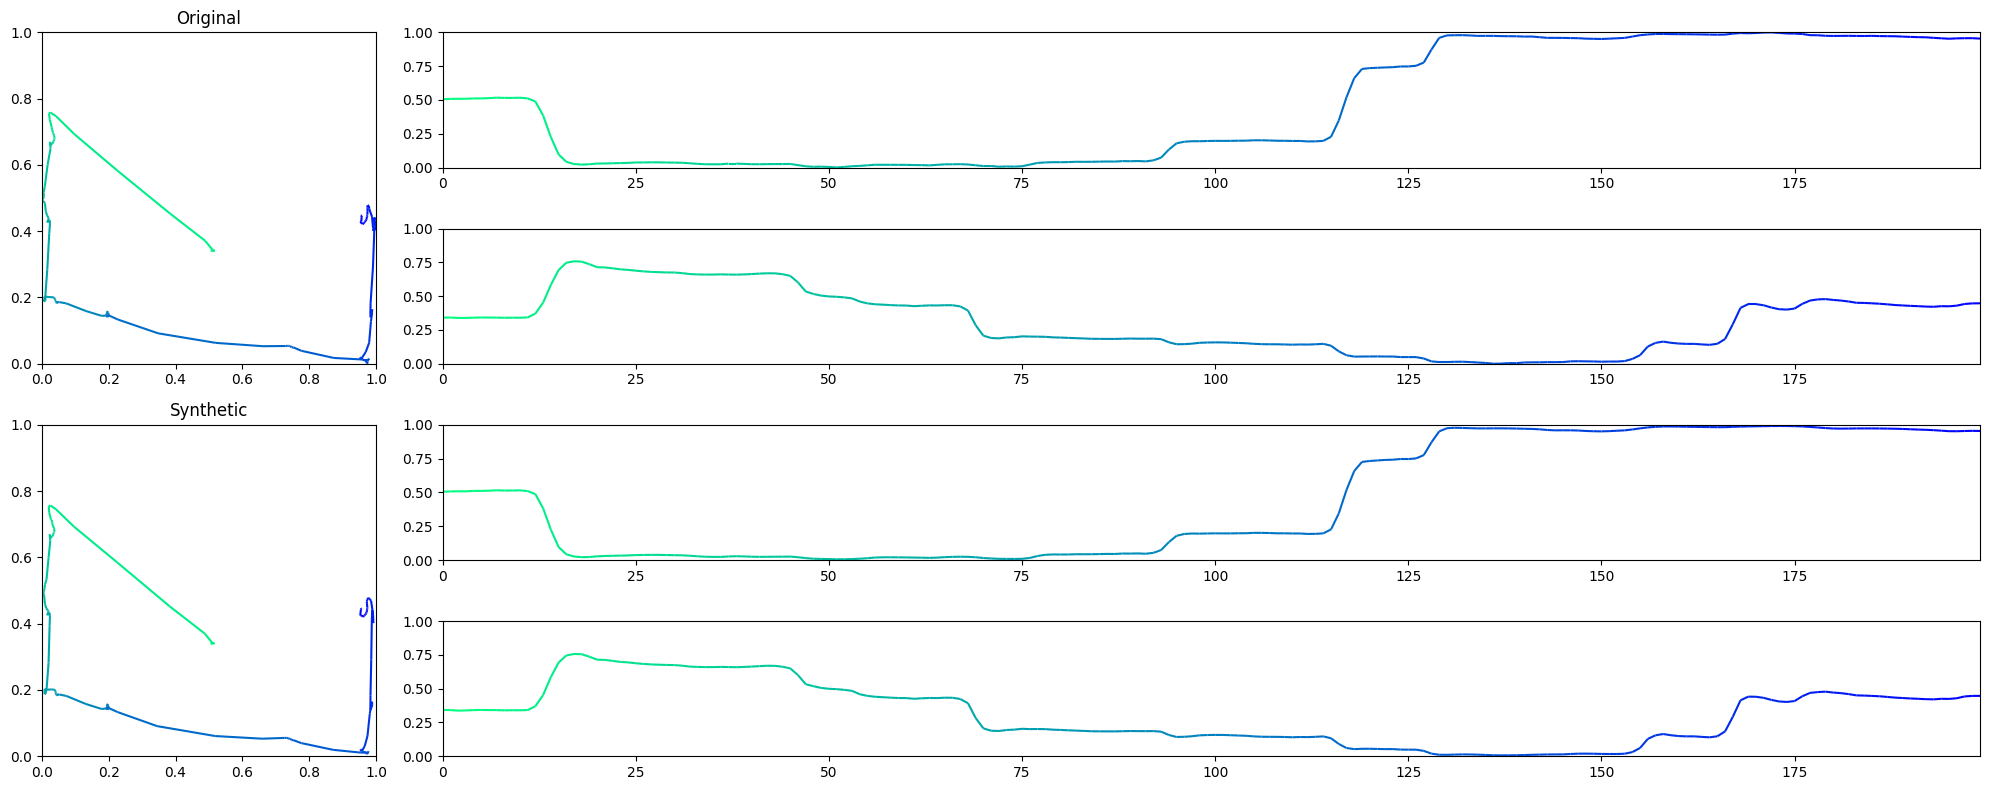

In [ ]:
i = 0
plot_data3(x[i], synth_data[i], None, "winter_r")

In [ ]:
# target_data = synth_data
# save_dir = f"/home/user/syn{pattern}"
# for i in range(len(synth_data)):
#     plot_data2(synth_data[i], f"{save_dir}/{i}.png", "gist_rainbow",   xlim1=[0, 1], ylim1=[0,1], ylim2=[0,1], ylim3=[0,1])

In [ ]:
save_dir = f"/home/user/custom_compare_images_{pattern}"

import os
import glob

files = glob.glob(f'{save_dir}/*.png')
for f in files:
    try:
        os.remove(f)
    except OSError as e:
        print("Error: %s : %s" % (f, e.strerror))

for i in range(len(synth_data)):
    plot_data3(x[i], synth_data[i], f"{save_dir}/{i}.png", "winter_r")